# Attribution for Data with Graphical Feature Depedencies

Packages

In [650]:
# Basics
import math
import random
from copy import deepcopy
from itertools import combinations
from collections import OrderedDict

# Simulation and data management
import numpy as np
import pandas as pd
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Scientific computing
import scipy as sp
import scipy.stats as stats
from scipy.stats import norm, beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate
from scipy.optimize import brentq, fsolve

# Model creation and training
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

# Custom
from generative_functions import set_seeds, eigen_centrality, generate_correlation, generate_features#, generate_from_linear, generate_from_nonlinear
from inferential_functions import BasicRegressionNN, train, standardize, lrp, relu, rho, incr
from plotting_functions import plot_predictions, heatmap, annotate_heatmap


Circumvent reloading kernel for custom packages

In [644]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GPU Setup

In [20]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Print CUDA device information
    print('CUDA devices:')
    for i in range(torch.cuda.device_count()):
        print(f"  Device {i}: {torch.cuda.get_device_name(i)}")

    # Use CUDA device for tensor operations
    device = torch.device('cuda')
    print('Using CUDA device:', torch.cuda.get_device_name(device))

CUDA devices:
  Device 0: NVIDIA GeForce GTX 1060
Using CUDA device: NVIDIA GeForce GTX 1060


Simulation Parameters

In [60]:
n = 10000 # Number of observations/instances
input_size = p = 10 # Number of covariates/features
hidden_sizes = [64, 32, 16]  # Three hidden layers with 32 and 16 units
output_size = 1  # Regression with a single output

## Linear

### Data Generation

In [326]:
set_seeds()
parameters = np.array([10,5,2,1,1,0,0,0,0,0]).reshape(p,1)
X_original = generate_features(n, p)
noise_sd = parameters.sum()/100
noise = np.random.normal(0, noise_sd, size=(n,1))
y_original = X_original @ parameters + noise
standardized = False

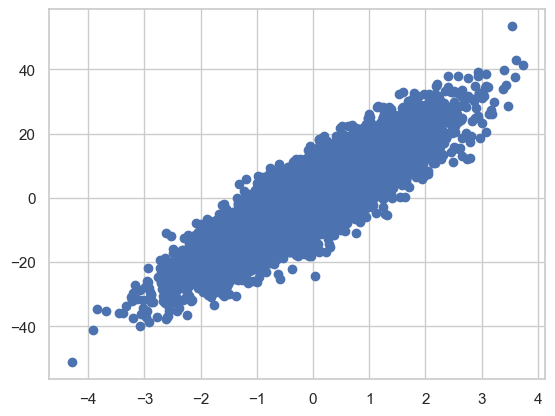

In [327]:
plt.plot(X_original[:,0], y_original, 'o')

### Model & Training

In [288]:
# Standardize
if standardized:
    X = standardize(X_original)
    y = standardize(y_original) 
else:
    X = X_original
    y = y_original

# Train test split
train_ratio = 0.8
train_size = int(train_ratio * n)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_t, y_t, X_train_t, y_train_t, X_test_t, y_test_t = (torch.tensor(data).to(device).type(torch.float32) for data in [X, y, X_train, y_train, X_test, y_test])

# Model
model1 = BasicRegressionNN(input_size, hidden_sizes, output_size, dropout_rate=0).to(device)
loss1 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
epochs = 5000
train(X_train_t, y_train_t, model1, loss1, optimizer1, epochs)

Epoch [100/5000], Loss: 138.4442
Epoch [200/5000], Loss: 135.8473
Epoch [300/5000], Loss: 128.0075
Epoch [400/5000], Loss: 112.3964
Epoch [500/5000], Loss: 88.1607
Epoch [600/5000], Loss: 59.7500
Epoch [700/5000], Loss: 34.2700
Epoch [800/5000], Loss: 17.0576
Epoch [900/5000], Loss: 8.2185
Epoch [1000/5000], Loss: 4.3510
Epoch [1100/5000], Loss: 2.6088
Epoch [1200/5000], Loss: 1.7447
Epoch [1300/5000], Loss: 1.2756
Epoch [1400/5000], Loss: 0.9973
Epoch [1500/5000], Loss: 0.8167
Epoch [1600/5000], Loss: 0.6940
Epoch [1700/5000], Loss: 0.6055
Epoch [1800/5000], Loss: 0.5399
Epoch [1900/5000], Loss: 0.4900
Epoch [2000/5000], Loss: 0.4515
Epoch [2100/5000], Loss: 0.4216
Epoch [2200/5000], Loss: 0.3970
Epoch [2300/5000], Loss: 0.3761
Epoch [2400/5000], Loss: 0.3582
Epoch [2500/5000], Loss: 0.3424
Epoch [2600/5000], Loss: 0.3280
Epoch [2700/5000], Loss: 0.3151
Epoch [2800/5000], Loss: 0.3031
Epoch [2900/5000], Loss: 0.2919
Epoch [3000/5000], Loss: 0.2810
Epoch [3100/5000], Loss: 0.2707
Epoch

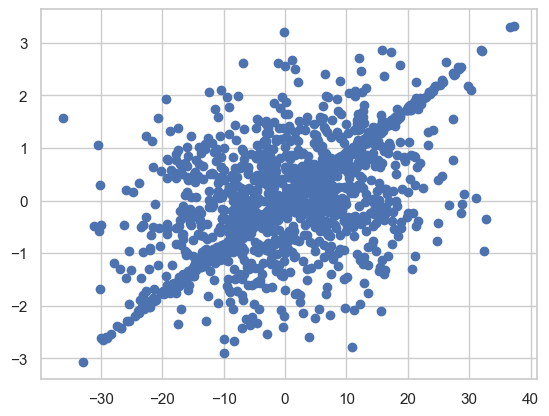

In [368]:
plot_predictions(model1(X_test_t.to('cpu')).to('cpu'), y_test)

### LRP and Explainability

Text(0, -120, '1. Trained on Unstandardized Features, 2. LRP Calculated with Bias')

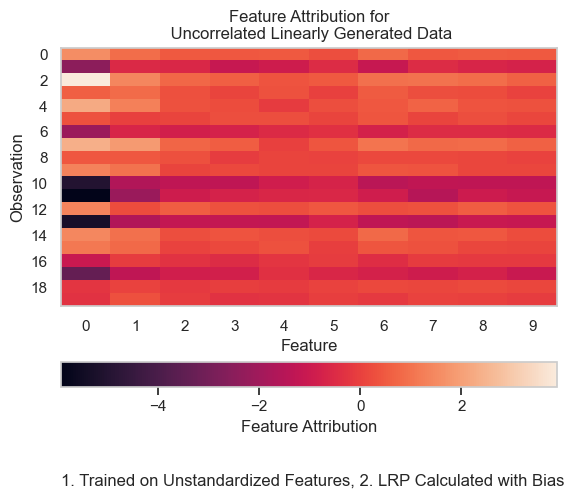

In [290]:
# Include bias in LRP calculation
has_bias = True

# Explanation
R = lrp(model1.to('cpu'), X_train, bias=has_bias)
explanation = R[0]

# Plot
plt.imshow(explanation[:20,], aspect='auto')
plt.grid(False)
plt.colorbar(location='bottom', label='Feature Attribution')
plt.xlabel('Feature')
plt.ylabel('Observation')
plt.xticks(range(0,10))
plt.yticks(range(0,20,2))
plt.title('Feature Attribution for\n Uncorrelated Linearly Generated Data')
bias_str = 'No '
if has_bias:
    bias_str = ''
std_str = 'Uns'
if standardized:
    std_str = 'S'
plt.annotate(f'1. Trained on {std_str}tandardized Features, 2. LRP Calculated with {bias_str}Bias', (0,0), (0, -120), xycoords='axes fraction', textcoords='offset points', va='top')

# Savefig
# plt.savefig(f'plots2/linear_{std_str.lower()}tandardized_{bias_str.lower().strip()}bias.png')

## Linear with Split Domain

### Data Generation

In [524]:
set_seeds()
parameters1 = np.array([10,5,2,1,1,0,0,0,0,1]).reshape(p,1)
parameters2 = np.array([0,5,2,1,1,0,0,0,-10,1]).reshape(p,1)
X_original = generate_features(n, p)

noise_sd = parameters.sum()/100
y_original = np.ones((n,1))
noise1 = np.random.normal(0, noise_sd, size=(n//2,1))
noise2 = np.random.normal(0, noise_sd, size=(n//2,1))
evens = list(range(0,n,2)) 
odds = list(range(1,n,2))
X_original[evens,9] = 1
X_original[odds,9] = 0
y_original[evens] = X_original[evens,] @ parameters1 + noise1
y_original[odds] = X_original[odds,] @ parameters2 + noise2

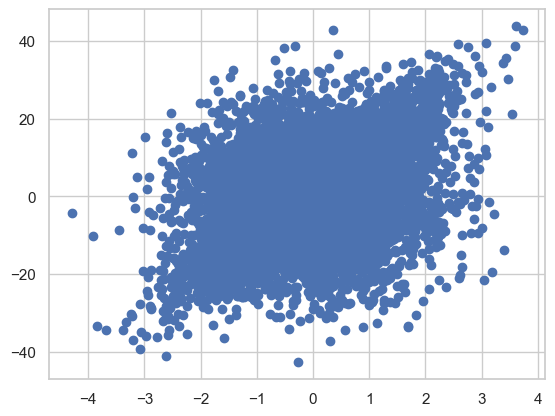

In [525]:
plt.plot(X_original[:,0], y_original[:], 'o')

### Model & Training

In [526]:
# Standardize
X = standardize(X_original)
y = standardize(y_original) 
# X = X_original
# y = y_original

# Train test split
train_ratio = 0.8
train_size = int(train_ratio * n)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Conver to tensors
X_t = torch.tensor(X).to(device)
y_t = torch.tensor(y).to(device)
X_train_t, X_test_t = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t, y_test_t = torch.tensor(y_train, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

# No batching for now

# # Prepare the training and testing sets as TensorDatasets
# train_dataset = TensorDataset(X_train_t, y_train_t)
# test_dataset = TensorDataset(X_test_t, y_test_t)

# # Create DataLoaders for both sets
# batch_size = 2000
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model2 = BasicRegressionNN(input_size, hidden_sizes, output_size, dropout_rate=.3).to(device)
loss2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
epochs = 5000
train(X_train_t, y_train_t, model2, loss2, optimizer2, epochs)

Epoch [100/5000], Loss: 1.0102
Epoch [200/5000], Loss: 0.8670
Epoch [300/5000], Loss: 0.6617
Epoch [400/5000], Loss: 0.5452
Epoch [500/5000], Loss: 0.4525
Epoch [600/5000], Loss: 0.3736
Epoch [700/5000], Loss: 0.3191
Epoch [800/5000], Loss: 0.2785
Epoch [900/5000], Loss: 0.2441
Epoch [1000/5000], Loss: 0.2253
Epoch [1100/5000], Loss: 0.2076
Epoch [1200/5000], Loss: 0.1914
Epoch [1300/5000], Loss: 0.1873
Epoch [1400/5000], Loss: 0.1739
Epoch [1500/5000], Loss: 0.1704
Epoch [1600/5000], Loss: 0.1666
Epoch [1700/5000], Loss: 0.1606
Epoch [1800/5000], Loss: 0.1564
Epoch [1900/5000], Loss: 0.1472
Epoch [2000/5000], Loss: 0.1451
Epoch [2100/5000], Loss: 0.1411
Epoch [2200/5000], Loss: 0.1431
Epoch [2300/5000], Loss: 0.1372
Epoch [2400/5000], Loss: 0.1395
Epoch [2500/5000], Loss: 0.1306
Epoch [2600/5000], Loss: 0.1316
Epoch [2700/5000], Loss: 0.1275
Epoch [2800/5000], Loss: 0.1265
Epoch [2900/5000], Loss: 0.1227
Epoch [3000/5000], Loss: 0.1222
Epoch [3100/5000], Loss: 0.1187
Epoch [3200/5000]

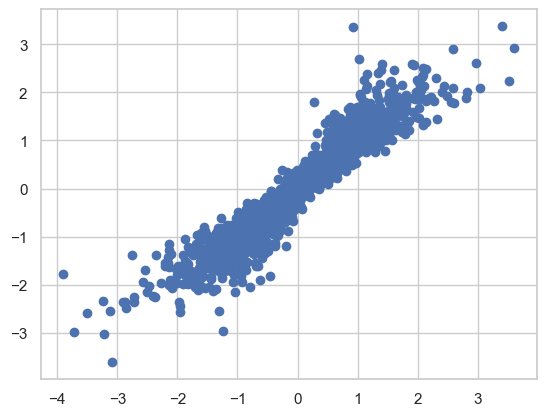

In [527]:
model2.to(device)
plot_predictions(model2(X_test_t).to('cpu'), y_test)

### LRP and Explainability

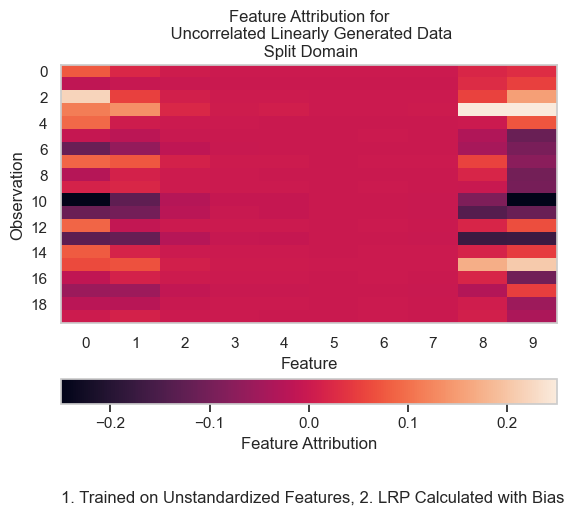

In [529]:
# Include bias in LRP calculation
has_bias = True

# Explanation
R = lrp(model2.to('cpu'), X_train, bias=has_bias)
explanation = R[0]

# Plot
plt.imshow(explanation[:20,], aspect='auto', vmin=-.25, vmax=.25)
plt.grid(False)
plt.colorbar(location='bottom', label='Feature Attribution')
plt.xlabel('Feature')
plt.ylabel('Observation')
plt.xticks(range(0,10))
plt.yticks(range(0,20,2))
plt.title('Feature Attribution for\n Uncorrelated Linearly Generated Data\n Split Domain')
bias_str = 'No '
if has_bias:
    bias_str = ''
std_str = 'Uns'
if standardized:
    std_str = 'S'
plt.annotate(f'1. Trained on {std_str}tandardized Features, 2. LRP Calculated with {bias_str}Bias', (0,0), (0, -120), xycoords='axes fraction', textcoords='offset points', va='top')

# Savefig
plt.savefig(f'plots2/linear_split_{std_str.lower()}tandardized_{bias_str.lower().strip()}bias_indicator_flip_flop.png')

## Linear with Correlation

### Generalizable Correlation Matrix Generation

Geneartion Correlation Matrices According to Hyperparameters and Measure Graph Metrics 

In [555]:
p = 10
W_rank = p//2
diag_strengths = [10, 50, 100, 500, 1000]
W_strengths = [1, 2, 3, 4, 5]

graph_metric_result = {}
for W_strength in W_strengths:
    for diag_strength in diag_strengths:

        W_relative = W_strength
        correlation = generate_correlation(p, diag_strength, W_rank, W_relative)
        key = (diag_strength, W_relative)
        eigen = eigen_centrality(correlation)
        eigen_normed = eigen/eigen.sum()
        eigen_info = {'eigen_last': np.round(1000*eigen_normed[len(eigen_normed)-1])/1000, 
                      'eigen_avg': np.round(1000*eigen_normed.mean())/1000, 
                      'eigen_entropy': np.round(1000*sp.stats.entropy(eigen_normed))/1000}
        graph_metric_result[key] = (correlation, eigen_info)

Visualize

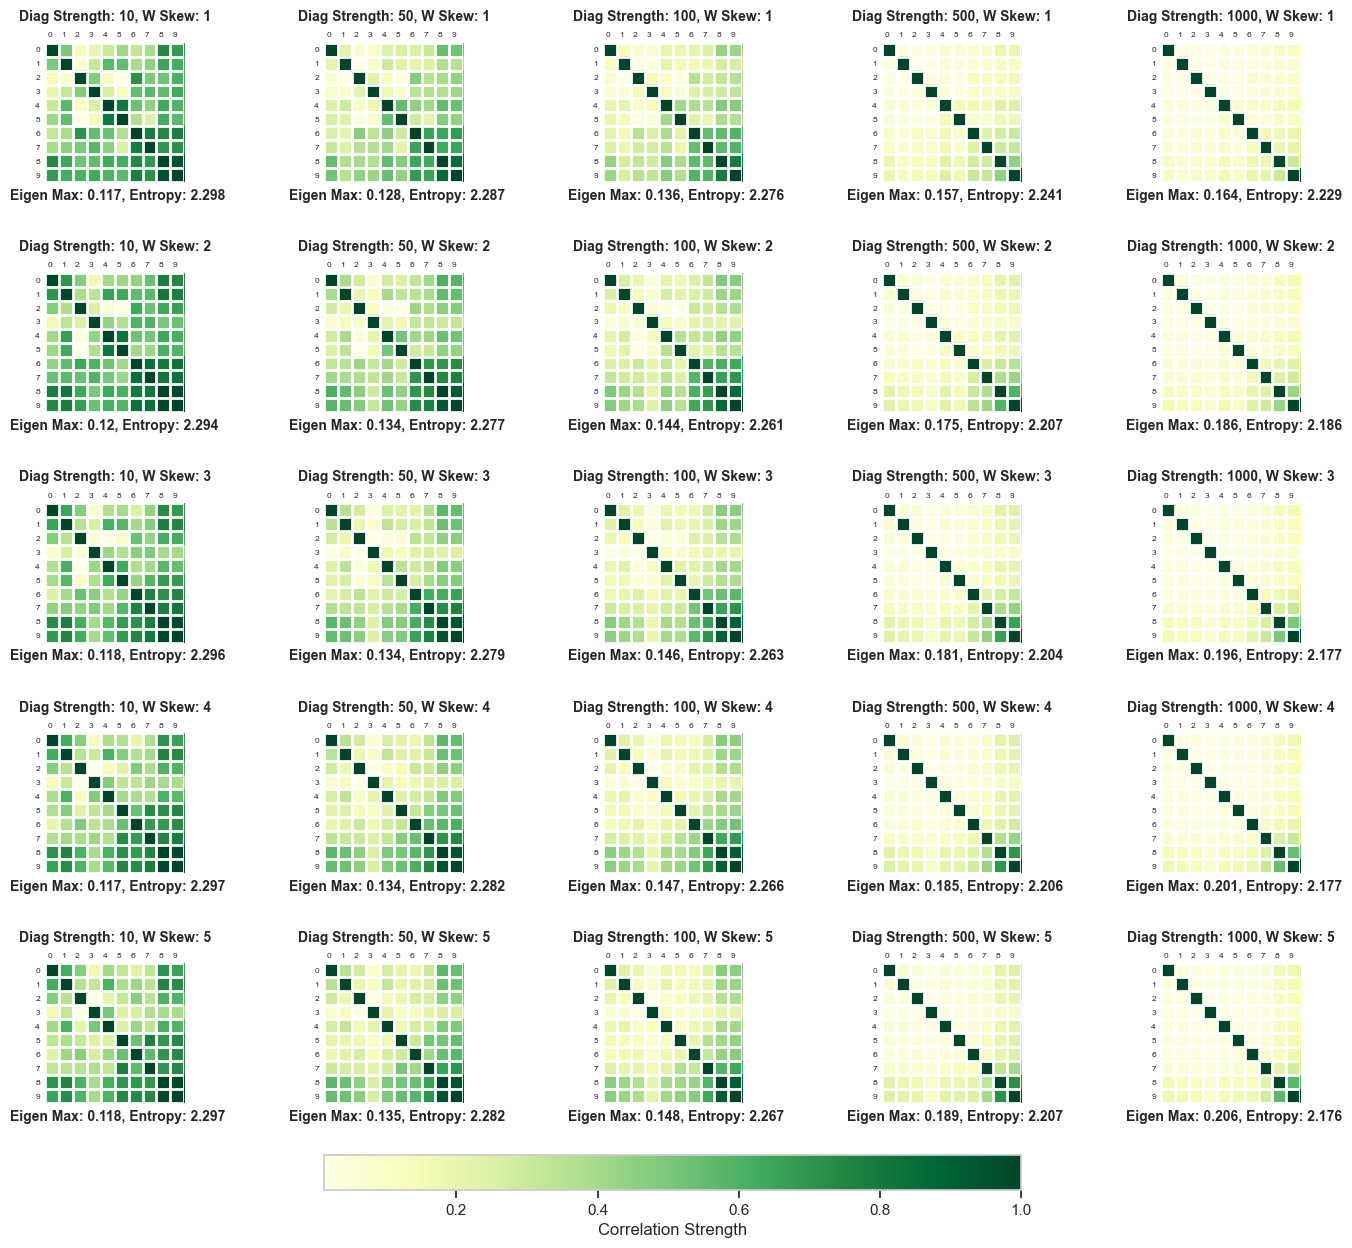

In [678]:
plt.ioff()
fig, ax = plt.subplots(5, 5, figsize=(18, 17))
fig.subplots_adjust(hspace=0.65, wspace=0)
for k, (key, (correlation, eigen_info)) in enumerate(graph_metric_result.items()):

    i = k // 5
    j = k % 5

    im = heatmap(correlation, np.arange(correlation.shape[0]), np.arange(correlation.shape[0]), ax=ax[i,j],
                    cmap="YlGn", cbarlabel="Correlation")
    #texts = annotate_heatmap(im, valfmt="{x:.2f}")

    ax[i,j].set_title(f"Diag Strength: {key[0]}, W Skew: {key[1]}", 
        fontdict={'fontsize': 10, 'fontweight' : "bold"}, pad=8)
    ax[i,j].text(-3, 10.75, f"Eigen Max: {eigen_info['eigen_last']}, Entropy: {eigen_info['eigen_entropy']}", 
        fontdict={'fontsize': 10, 'fontweight' : "bold"})
    # plt.savefig(f"plots/correlation_diag_{key[0]}_Wr_{key[1]}", bbox_inches='tight', pad_inches=.25)
    
    # if k == 0:  # Example: add a single color bar to the first subplot for simplicity
    #     fig.colorbar(im, ax=ax[i, j])

# Creating a single color bar for the entire figure
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal', pad=0.04, shrink=.5)
cbar.set_label('Correlation Strength')
plt.savefig(f"plots/all_correlations", bbox_inches='tight')

plt.show()

Organize Correlation Matrices by Graph Metrics

In [630]:
# The goal here is to create correlation matrices induced by dependency graphs as a function of 1. maximum eigenvalue centrality and 2. eigenvalue centrality entropy
eigen_entropy_to_corr = {}
eigen_max_to_corr = {}
for __, (correlation, eigen_info) in graph_metric_result.items():

    # Create the eigen information as keys
    eigen_last = eigen_info['eigen_last']
    eigen_entropy= eigen_info['eigen_entropy']

    # Point them to their corresponding correlation matrices
    eigen_max_to_corr[eigen_last] = correlation
    eigen_entropy_to_corr[eigen_entropy] = correlation

eigen_max_to_corr = OrderedDict(eigen_max_to_corr)
eigen_entropy_to_corr = OrderedDict(eigen_entropy_to_corr)

In [636]:
eigen_maxs = list(eigen_max_to_corr.keys())
eigen_maxs[0], eigen_max_to_corr[eigen_maxs[0]]
correlation = eigen_max_to_corr[eigen_maxs[0]]

### Data Generation, Model & Training, LRP and Explainability Version 1

Epoch [100/5000], Loss: 0.8565
Epoch [200/5000], Loss: 0.5177
Epoch [300/5000], Loss: 0.3877
Epoch [400/5000], Loss: 0.2509
Epoch [500/5000], Loss: 0.1963
Epoch [600/5000], Loss: 0.1790
Epoch [700/5000], Loss: 0.1608
Epoch [800/5000], Loss: 0.1558
Epoch [900/5000], Loss: 0.1520
Epoch [1000/5000], Loss: 0.1424
Epoch [1100/5000], Loss: 0.1371
Epoch [1200/5000], Loss: 0.1301
Epoch [1300/5000], Loss: 0.1255
Epoch [1400/5000], Loss: 0.1236
Epoch [1500/5000], Loss: 0.1250
Epoch [1600/5000], Loss: 0.1222
Epoch [1700/5000], Loss: 0.1156
Epoch [1800/5000], Loss: 0.1106
Epoch [1900/5000], Loss: 0.1103
Epoch [2000/5000], Loss: 0.1153
Epoch [2100/5000], Loss: 0.1136
Epoch [2200/5000], Loss: 0.1071
Epoch [2300/5000], Loss: 0.1120
Epoch [2400/5000], Loss: 0.1113
Epoch [2500/5000], Loss: 0.1063
Epoch [2600/5000], Loss: 0.1078
Epoch [2700/5000], Loss: 0.1024
Epoch [2800/5000], Loss: 0.1078
Epoch [2900/5000], Loss: 0.1104
Epoch [3000/5000], Loss: 0.1007
Epoch [3100/5000], Loss: 0.1003
Epoch [3200/5000]

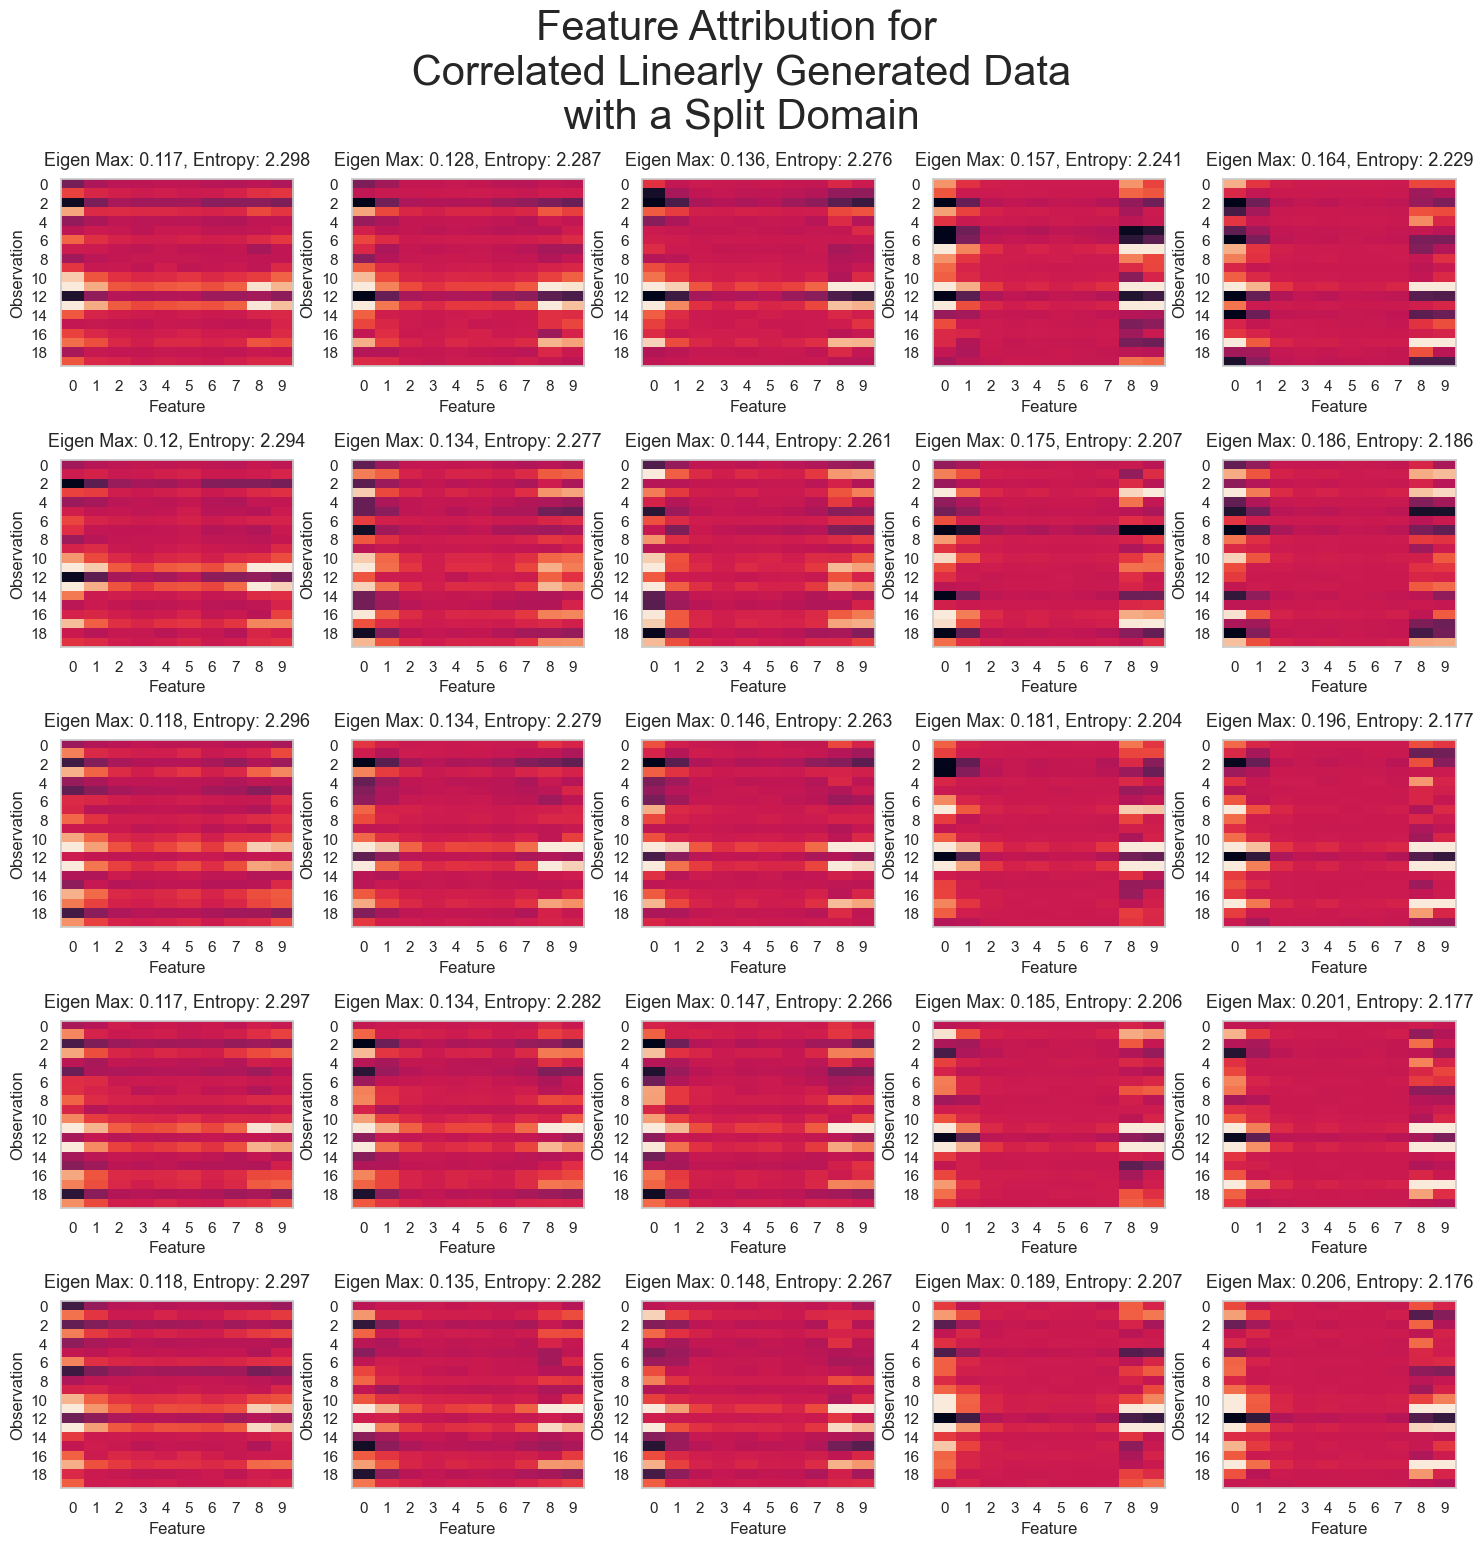

In [676]:
set_seeds()
plt.ioff()
fig, ax = plt.subplots(5, 5, figsize=(18, 17))
fig.subplots_adjust(hspace=0.5, wspace=.25)

for k, (key, (correlation, eigen_info)) in enumerate(graph_metric_result.items()):


    ## Data generation

    parameters1 = np.array([10,5,2,1,1,0,0,0,1,0]).reshape(p,1)
    parameters2 = np.array([10,5,2,1,1,0,0,0,1,10]).reshape(p,1)
    X_original = generate_features(n, p, correlation)
    noise_sd = parameters.sum()/100
    y_original = np.ones((n,1))
    noise1 = np.random.normal(0, noise_sd, size=(n//2,1))
    noise2 = np.random.normal(0, noise_sd, size=(n//2,1))
    evens = list(range(0,n,2)) 
    odds = list(range(1,n,2))
    X_original[evens,8] = 1
    X_original[odds,8] = 0
    y_original[evens] = X_original[evens,] @ parameters1 + noise1
    y_original[odds] = X_original[odds,] @ parameters2 + noise2


    ## Model and Training

    # Standardize
    X = standardize(X_original)
    y = standardize(y_original) 
    # X = X_original
    # y = y_original

    # Train test split
    train_ratio = 0.8
    train_size = int(train_ratio * n)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Conver to tensors
    X_t = torch.tensor(X).to(device)
    y_t = torch.tensor(y).to(device)
    X_train_t, X_test_t = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_t, y_test_t = torch.tensor(y_train, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

    # No batching for now

    # # Prepare the training and testing sets as TensorDatasets
    # train_dataset = TensorDataset(X_train_t, y_train_t)
    # test_dataset = TensorDataset(X_test_t, y_test_t)

    # # Create DataLoaders for both sets
    # batch_size = 2000
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model3 = BasicRegressionNN(input_size, hidden_sizes, output_size, dropout_rate=.3).to(device)
    loss3 = nn.MSELoss()
    optimizer3 = optim.Adam(model3.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    epochs = 5000
    train(X_train_t, y_train_t, model3, loss3, optimizer3, epochs)


    ## LRP and explainability

    # Include bias in LRP calculation
    has_bias = True

    # Explanation
    R = lrp(model3.to('cpu'), X_train, bias=has_bias)
    explanation = R[0]

    i = k // 5
    j = k % 5

    # Plot
    ax[i,j].imshow(explanation[:20,], aspect='auto', vmin=-.25, vmax=.25)
    ax[i,j].grid(False)
    #ax[i,j].colorbar(location='bottom', label='Feature Attribution')
    ax[i,j].set_xlabel('Feature')
    ax[i,j].set_ylabel('Observation')
    ax[i,j].set_xticks(range(0,10))
    ax[i,j].set_yticks(range(0,20,2))
    ax[i,j].set_title(f"Eigen Max: {eigen_info['eigen_last']}, Entropy: {eigen_info['eigen_entropy']}", fontdict={'fontsize': 13}, pad=10)
    #ax[i,j].set_title('Feature Attribution for\n Correlated Linearly Generated Data\n Split Domain')
    bias_str = 'No '
    if has_bias:
        bias_str = ''
    std_str = 'Uns'
    if standardized:
        std_str = 'S'
    #plt.annotate(f'1. Trained on {std_str}tandardized Features, 2. LRP Calculated with {bias_str}Bias', (0,0), (0, -120), xycoords='axes fraction', textcoords='offset points', va='top')

# Creating a single color bar for the entire figure
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal', pad=0.04, shrink=.5)
cbar.set_label('Feature Attribution')

# Savefig
plt.savefig(f'plots2/correlated_linear_split_{std_str.lower()}tandardized_{bias_str.lower().strip()}bias_indicator.png')
fig.suptitle('Feature Attribution for\n Correlated Linearly Generated Data\n with a Split Domain', fontsize=30)
plt.show()


#     im = heatmap(correlation, np.arange(correlation.shape[0]), np.arange(correlation.shape[0]), ax=ax[i,j],
#                     cmap="YlGn", cbarlabel="Correlation")
#     #texts = annotate_heatmap(im, valfmt="{x:.2f}")

#     ax[i,j].set_title(f"Diag Strength: {key[0]}, W Skew: {key[1]}", 
#         fontdict={'fontsize': 10, 'fontweight' : "bold"}, pad=8)
#     ax[i,j].text(-3, 10.75, f"Eigen Max: {eigen_info['eigen_last']}, Entropy: {eigen_info['eigen_entropy']}", 
#         fontdict={'fontsize': 10, 'fontweight' : "bold"})
#     # plt.savefig(f"plots/correlation_diag_{key[0]}_Wr_{key[1]}", bbox_inches='tight', pad_inches=.25)
    
#     # if k == 0:  # Example: add a single color bar to the first subplot for simplicity
#     #     fig.colorbar(im, ax=ax[i, j])



# plt.show()

### Data Generation, Model & Training, LRP and Explainability Version 2

Epoch [100/5000], Loss: 0.8225
Epoch [200/5000], Loss: 0.4610
Epoch [300/5000], Loss: 0.3069
Epoch [400/5000], Loss: 0.2077
Epoch [500/5000], Loss: 0.1776
Epoch [600/5000], Loss: 0.1737
Epoch [700/5000], Loss: 0.1562
Epoch [800/5000], Loss: 0.1501
Epoch [900/5000], Loss: 0.1449
Epoch [1000/5000], Loss: 0.1368
Epoch [1100/5000], Loss: 0.1323
Epoch [1200/5000], Loss: 0.1280
Epoch [1300/5000], Loss: 0.1250
Epoch [1400/5000], Loss: 0.1213
Epoch [1500/5000], Loss: 0.1207
Epoch [1600/5000], Loss: 0.1205
Epoch [1700/5000], Loss: 0.1150
Epoch [1800/5000], Loss: 0.1094
Epoch [1900/5000], Loss: 0.1090
Epoch [2000/5000], Loss: 0.1142
Epoch [2100/5000], Loss: 0.1128
Epoch [2200/5000], Loss: 0.1039
Epoch [2300/5000], Loss: 0.1117
Epoch [2400/5000], Loss: 0.1093
Epoch [2500/5000], Loss: 0.1052
Epoch [2600/5000], Loss: 0.1093
Epoch [2700/5000], Loss: 0.1015
Epoch [2800/5000], Loss: 0.1051
Epoch [2900/5000], Loss: 0.1100
Epoch [3000/5000], Loss: 0.1027
Epoch [3100/5000], Loss: 0.0993
Epoch [3200/5000]

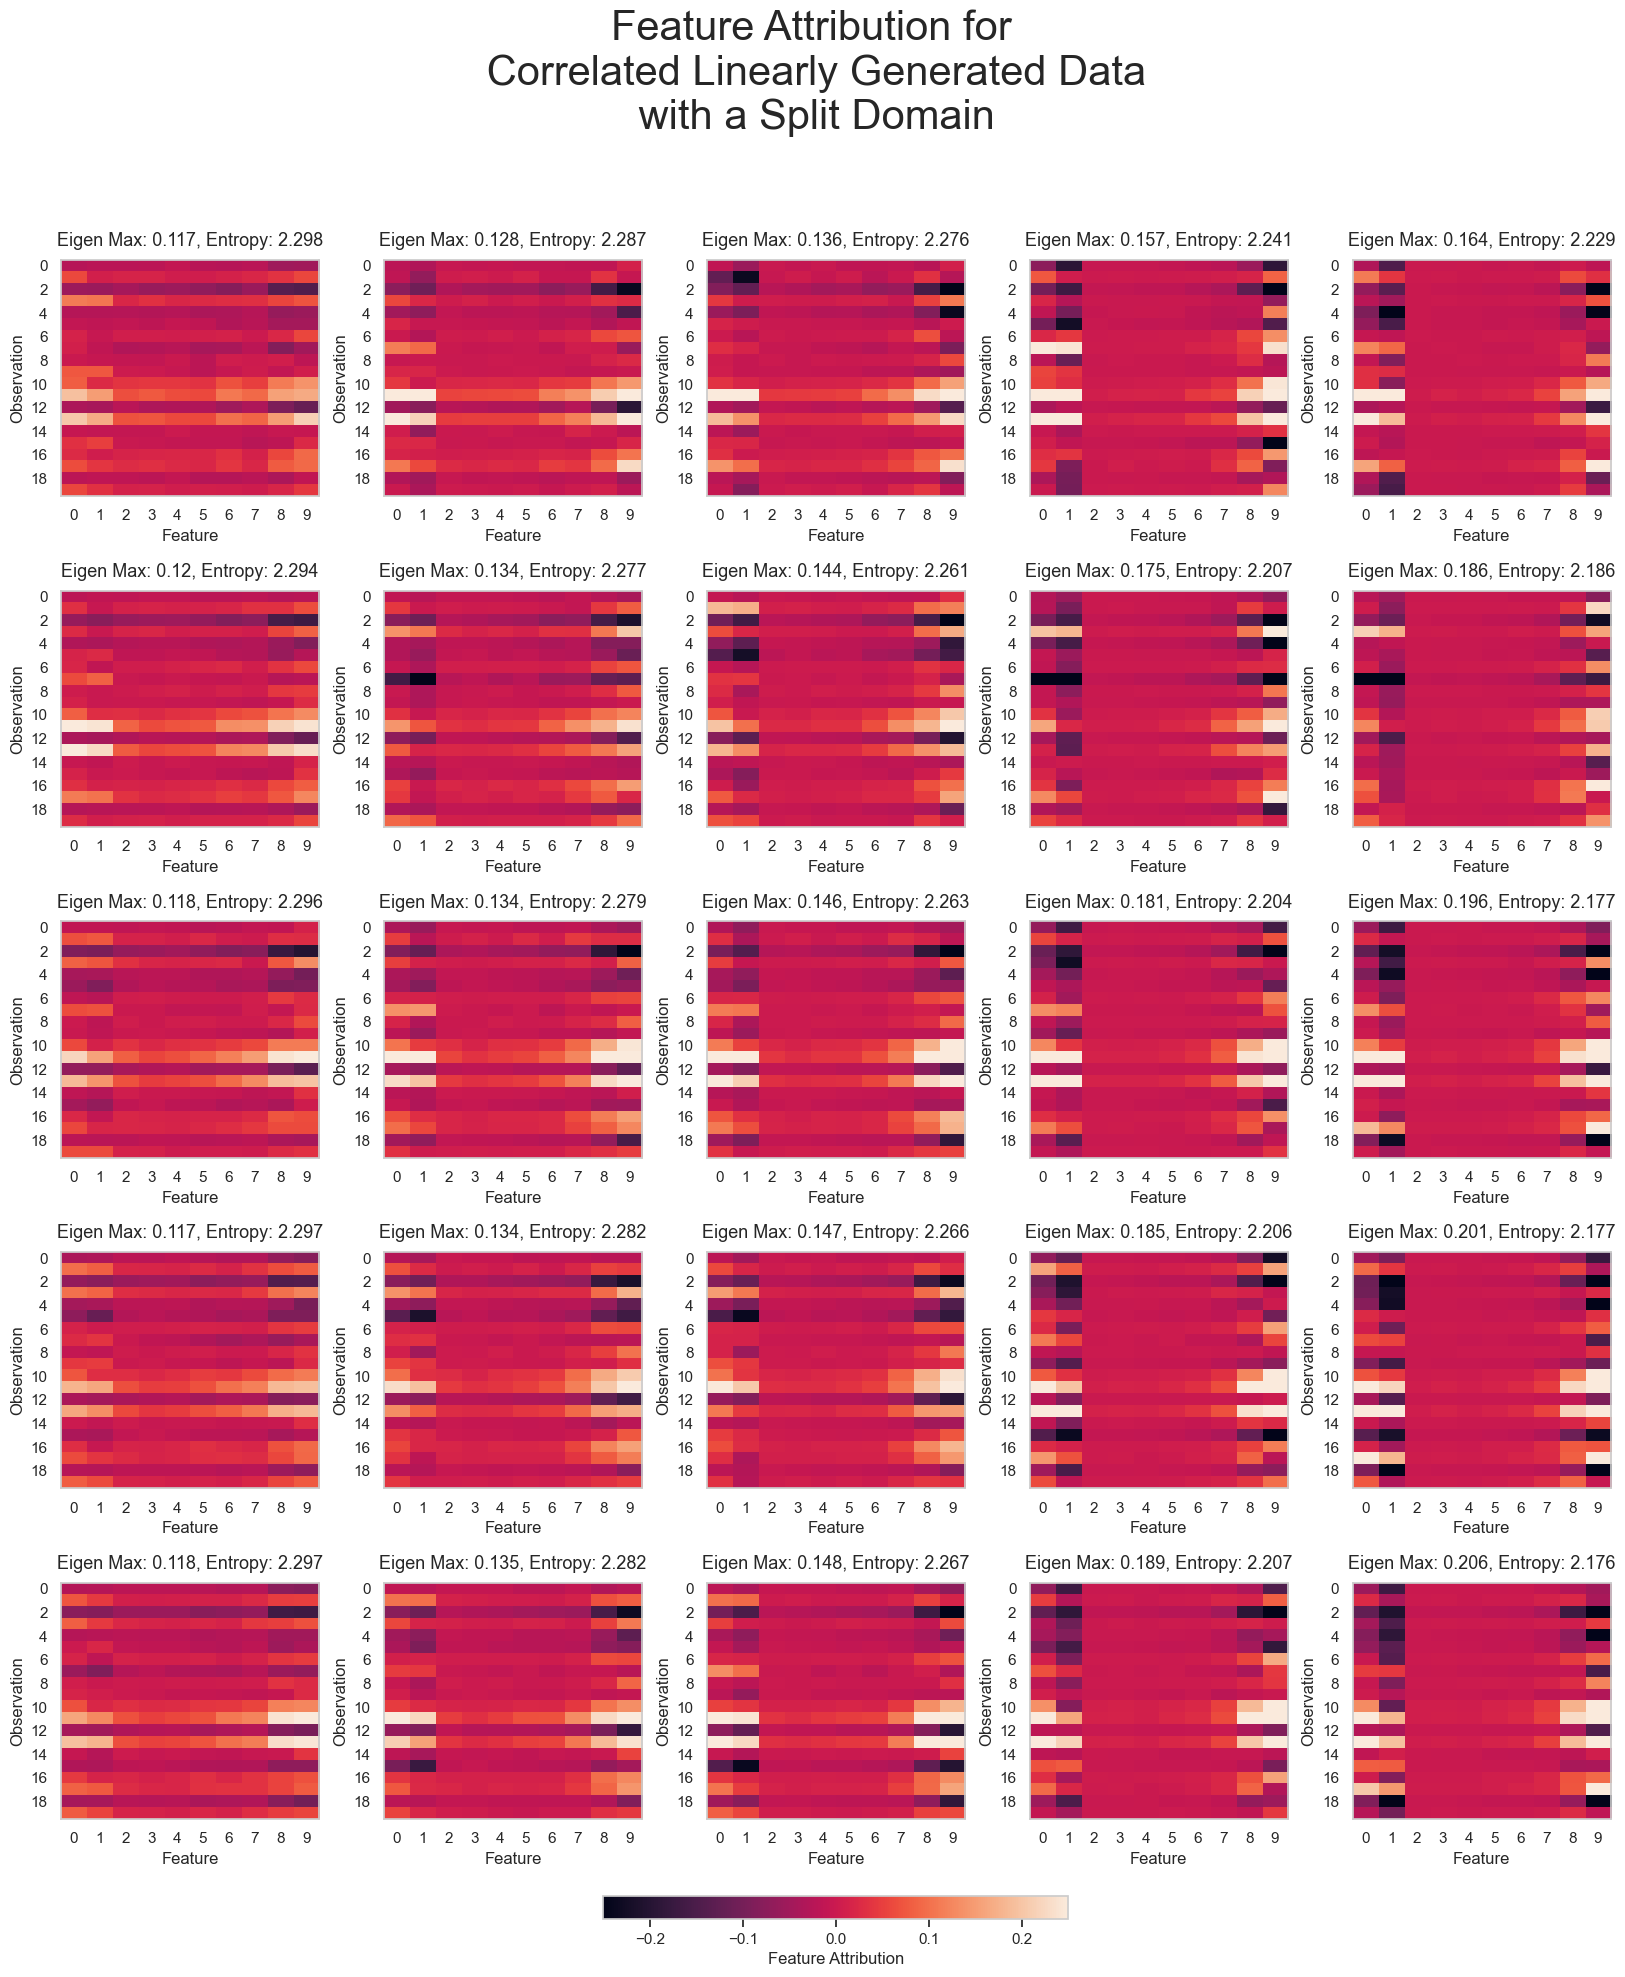

In [689]:
set_seeds()
plt.ioff()
fig, ax = plt.subplots(5, 5, figsize=(20, 25))
fig.subplots_adjust(hspace=0.4, wspace=.25)

for k, (key, (correlation, eigen_info)) in enumerate(graph_metric_result.items()):


    ## Data generation

    parameters1 = np.flip(np.array([10,5,2,1,1,0,0,0,1,0])).reshape(p,1)
    parameters2 = np.flip(np.array([10,5,2,1,1,0,0,0,1,10])).reshape(p,1)
    X_original = generate_features(n, p, correlation)
    noise_sd = parameters.sum()/100
    y_original = np.ones((n,1))
    noise1 = np.random.normal(0, noise_sd, size=(n//2,1))
    noise2 = np.random.normal(0, noise_sd, size=(n//2,1))
    evens = list(range(0,n,2)) 
    odds = list(range(1,n,2))
    X_original[evens,1] = 1
    X_original[odds,1] = 0
    y_original[evens] = X_original[evens,] @ parameters1 + noise1
    y_original[odds] = X_original[odds,] @ parameters2 + noise2


    ## Model and Training

    # Standardize
    X = standardize(X_original)
    y = standardize(y_original) 
    # X = X_original
    # y = y_original

    # Train test split
    train_ratio = 0.8
    train_size = int(train_ratio * n)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Conver to tensors
    X_t = torch.tensor(X).to(device)
    y_t = torch.tensor(y).to(device)
    X_train_t, X_test_t = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_t, y_test_t = torch.tensor(y_train, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

    # No batching for now

    # # Prepare the training and testing sets as TensorDatasets
    # train_dataset = TensorDataset(X_train_t, y_train_t)
    # test_dataset = TensorDataset(X_test_t, y_test_t)

    # # Create DataLoaders for both sets
    # batch_size = 2000
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model3 = BasicRegressionNN(input_size, hidden_sizes, output_size, dropout_rate=.3).to(device)
    loss3 = nn.MSELoss()
    optimizer3 = optim.Adam(model3.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    epochs = 5000
    train(X_train_t, y_train_t, model3, loss3, optimizer3, epochs)


    ## LRP and explainability

    # Include bias in LRP calculation
    has_bias = True

    # Explanation
    R = lrp(model3.to('cpu'), X_train, bias=has_bias)
    explanation = R[0]

    i = k // 5
    j = k % 5

    # Plot
    im = ax[i,j].imshow(explanation[:20,], aspect='auto', vmin=-.25, vmax=.25)
    ax[i,j].grid(False)
    #ax[i,j].colorbar(location='bottom', label='Feature Attribution')
    ax[i,j].set_xlabel('Feature')
    ax[i,j].set_ylabel('Observation')
    ax[i,j].set_xticks(range(0,10))
    ax[i,j].set_yticks(range(0,20,2))
    ax[i,j].set_title(f"Eigen Max: {eigen_info['eigen_last']}, Entropy: {eigen_info['eigen_entropy']}", fontdict={'fontsize': 13}, pad=10)
    #ax[i,j].set_title('Feature Attribution for\n Correlated Linearly Generated Data\n Split Domain')
    bias_str = 'No '
    if has_bias:
        bias_str = ''
    std_str = 'Uns'
    if standardized:
        std_str = 'S'
    #plt.annotate(f'1. Trained on {std_str}tandardized Features, 2. LRP Calculated with {bias_str}Bias', (0,0), (0, -120), xycoords='axes fraction', textcoords='offset points', va='top')

# Creating a single color bar for the entire figure
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal', pad=0.04, shrink=.3)
cbar.set_label('Feature Attribution')

# Savefig
plt.savefig(f'plots2/correlated_linear_split_{std_str.lower()}tandardized_{bias_str.lower().strip()}bias_indicator_correlation_on_all.png')
fig.suptitle('Feature Attribution for\n Correlated Linearly Generated Data\n with a Split Domain', fontsize=30)
plt.show()


#     im = heatmap(correlation, np.arange(correlation.shape[0]), np.arange(correlation.shape[0]), ax=ax[i,j],
#                     cmap="YlGn", cbarlabel="Correlation")
#     #texts = annotate_heatmap(im, valfmt="{x:.2f}")

#     ax[i,j].set_title(f"Diag Strength: {key[0]}, W Skew: {key[1]}", 
#         fontdict={'fontsize': 10, 'fontweight' : "bold"}, pad=8)
#     ax[i,j].text(-3, 10.75, f"Eigen Max: {eigen_info['eigen_last']}, Entropy: {eigen_info['eigen_entropy']}", 
#         fontdict={'fontsize': 10, 'fontweight' : "bold"})
#     # plt.savefig(f"plots/correlation_diag_{key[0]}_Wr_{key[1]}", bbox_inches='tight', pad_inches=.25)
    
#     # if k == 0:  # Example: add a single color bar to the first subplot for simplicity
#     #     fig.colorbar(im, ax=ax[i, j])

# # Creating a single color bar for the entire figure
# cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal', pad=0.04, shrink=.5)
# cbar.set_label('Correlation Strength')

# plt.show()

## Nonlinear Data Generation

### Data Generation, Model & Training, LRP and Explainability

Epoch [100/5000], Loss: 0.8565
Epoch [200/5000], Loss: 0.5177
Epoch [300/5000], Loss: 0.3877
Epoch [400/5000], Loss: 0.2509
Epoch [500/5000], Loss: 0.1963
Epoch [600/5000], Loss: 0.1790
Epoch [700/5000], Loss: 0.1608
Epoch [800/5000], Loss: 0.1558
Epoch [900/5000], Loss: 0.1520
Epoch [1000/5000], Loss: 0.1424
Epoch [1100/5000], Loss: 0.1371
Epoch [1200/5000], Loss: 0.1301
Epoch [1300/5000], Loss: 0.1255
Epoch [1400/5000], Loss: 0.1236
Epoch [1500/5000], Loss: 0.1250
Epoch [1600/5000], Loss: 0.1222
Epoch [1700/5000], Loss: 0.1156
Epoch [1800/5000], Loss: 0.1106
Epoch [1900/5000], Loss: 0.1103
Epoch [2000/5000], Loss: 0.1153
Epoch [2100/5000], Loss: 0.1136
Epoch [2200/5000], Loss: 0.1071
Epoch [2300/5000], Loss: 0.1120
Epoch [2400/5000], Loss: 0.1113
Epoch [2500/5000], Loss: 0.1063
Epoch [2600/5000], Loss: 0.1078
Epoch [2700/5000], Loss: 0.1024
Epoch [2800/5000], Loss: 0.1078
Epoch [2900/5000], Loss: 0.1104
Epoch [3000/5000], Loss: 0.1007
Epoch [3100/5000], Loss: 0.1003
Epoch [3200/5000]

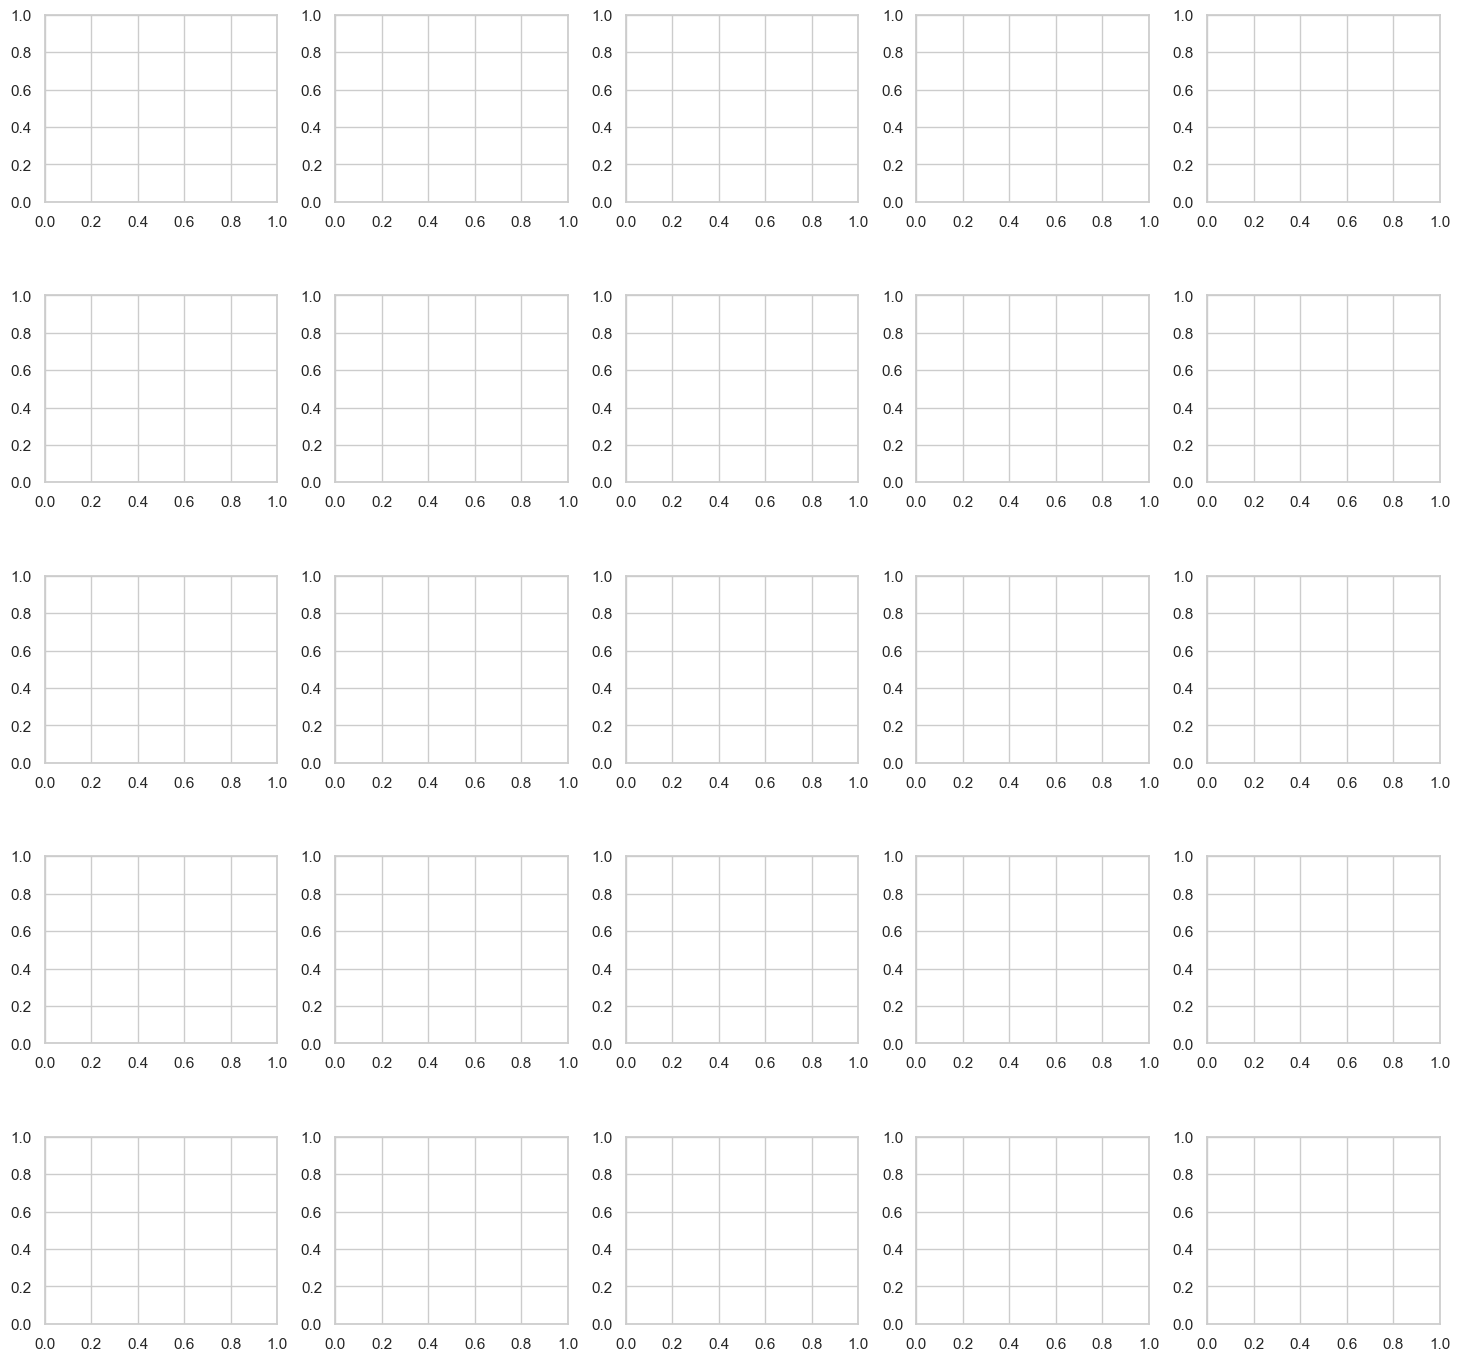

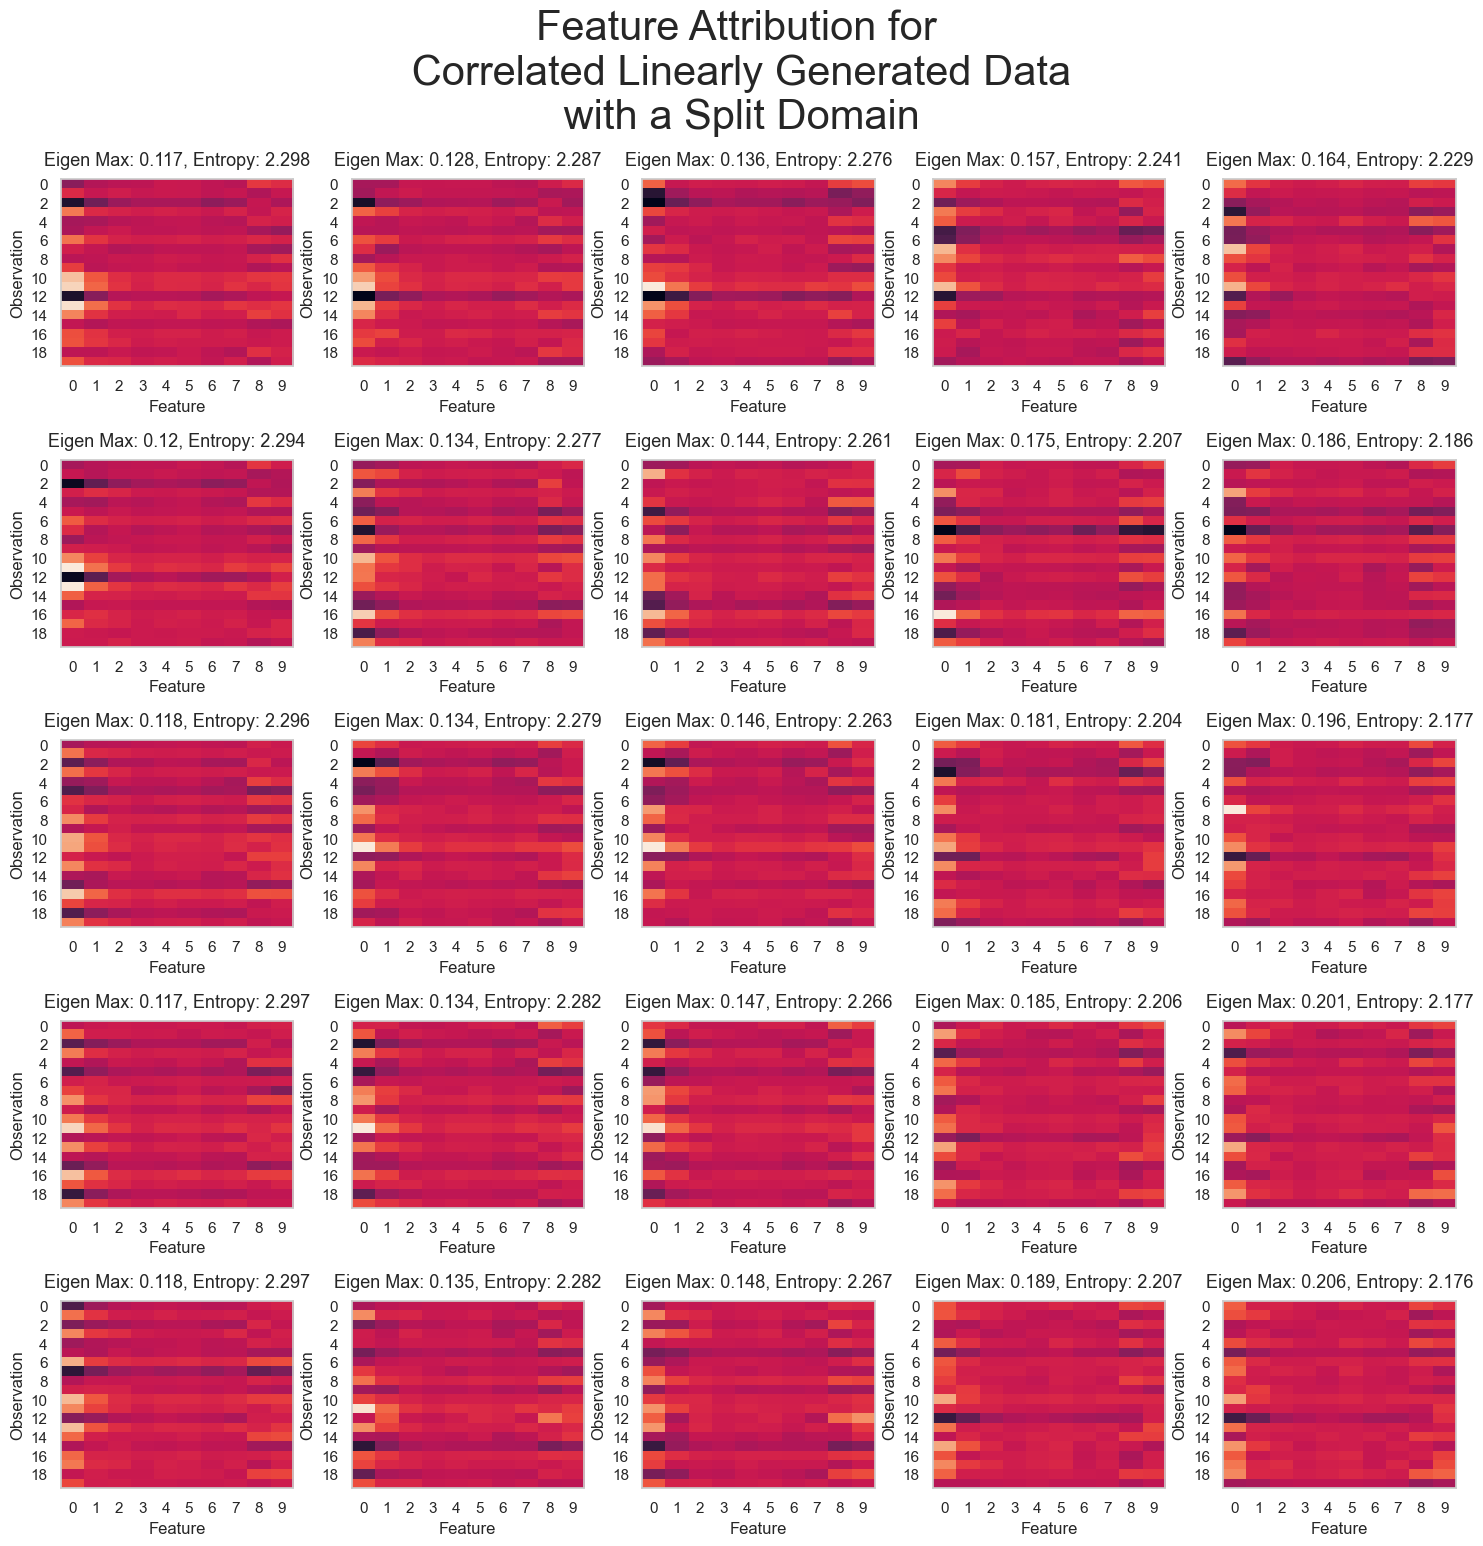

In [ ]:
set_seeds()
plt.ioff()
fig, ax = plt.subplots(5, 5, figsize=(18, 17))
fig.subplots_adjust(hspace=0.5, wspace=.25)

for k, (key, (correlation, eigen_info)) in enumerate(graph_metric_result.items()):


    ## Data generation

    parameters1 = np.array([10,5,2,1,1,0,0,0,1,0]).reshape(p,1)
    parameters2 = np.array([10,5,2,1,1,0,0,0,1,10]).reshape(p,1)
    X_original = generate_features(n, p, correlation)
    
    X_original[:,1] = np.exp(X_original[:,1])
    X_original[:,3] = np.exp(X_original[:,3])
    X_original[:,5] = np.exp(X_original[:,5])
    X_original[:,5] = np.exp(X_original[:,7])

    noise_sd = parameters.sum()/100
    y_original = np.ones((n,1))
    noise1 = np.random.normal(0, noise_sd, size=(n//2,1))
    noise2 = np.random.normal(0, noise_sd, size=(n//2,1))
    evens = list(range(0,n,2)) 
    odds = list(range(1,n,2))
    X_original[evens,8] = 1
    X_original[odds,8] = 0
    y_original[evens] = X_original[evens,] @ parameters1 + noise1
    y_original[odds] = X_original[odds,] @ parameters2 + noise2


    ## Model and Training

    # Standardize
    X = standardize(X_original)
    y = standardize(y_original) 
    # X = X_original
    # y = y_original

    # Train test split
    train_ratio = 0.8
    train_size = int(train_ratio * n)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Conver to tensors
    X_t = torch.tensor(X).to(device)
    y_t = torch.tensor(y).to(device)
    X_train_t, X_test_t = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_t, y_test_t = torch.tensor(y_train, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

    # No batching for now

    # # Prepare the training and testing sets as TensorDatasets
    # train_dataset = TensorDataset(X_train_t, y_train_t)
    # test_dataset = TensorDataset(X_test_t, y_test_t)

    # # Create DataLoaders for both sets
    # batch_size = 2000
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model3 = BasicRegressionNN(input_size, hidden_sizes, output_size, dropout_rate=.3).to(device)
    loss3 = nn.MSELoss()
    optimizer3 = optim.Adam(model3.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    epochs = 5000
    train(X_train_t, y_train_t, model3, loss3, optimizer3, epochs)


    ## LRP and explainability

    # Include bias in LRP calculation
    has_bias = True

    # Explanation
    R = lrp(model2.to('cpu'), X_train, bias=has_bias)
    explanation = R[0]

    i = k // 5
    j = k % 5

    # Plot
    ax[i,j].imshow(explanation[:20,], aspect='auto', vmin=-.25, vmax=.25)
    ax[i,j].grid(False)
    #ax[i,j].colorbar(location='bottom', label='Feature Attribution')
    ax[i,j].set_xlabel('Feature')
    ax[i,j].set_ylabel('Observation')
    ax[i,j].set_xticks(range(0,10))
    ax[i,j].set_yticks(range(0,20,2))
    ax[i,j].set_title(f"Eigen Max: {eigen_info['eigen_last']}, Entropy: {eigen_info['eigen_entropy']}", fontdict={'fontsize': 13}, pad=10)
    #ax[i,j].set_title('Feature Attribution for\n Correlated Linearly Generated Data\n Split Domain')
    bias_str = 'No '
    if has_bias:
        bias_str = ''
    std_str = 'Uns'
    if standardized:
        std_str = 'S'
    #plt.annotate(f'1. Trained on {std_str}tandardized Features, 2. LRP Calculated with {bias_str}Bias', (0,0), (0, -120), xycoords='axes fraction', textcoords='offset points', va='top')

# Savefig
plt.savefig(f'plots2/correlated_linear_split_{std_str.lower()}tandardized_{bias_str.lower().strip()}bias_indicator.png')
fig.suptitle('Feature Attribution for\n Correlated Linearly Generated Data\n with a Split Domain', fontsize=30)
plt.show()


#     im = heatmap(correlation, np.arange(correlation.shape[0]), np.arange(correlation.shape[0]), ax=ax[i,j],
#                     cmap="YlGn", cbarlabel="Correlation")
#     #texts = annotate_heatmap(im, valfmt="{x:.2f}")

#     ax[i,j].set_title(f"Diag Strength: {key[0]}, W Skew: {key[1]}", 
#         fontdict={'fontsize': 10, 'fontweight' : "bold"}, pad=8)
#     ax[i,j].text(-3, 10.75, f"Eigen Max: {eigen_info['eigen_last']}, Entropy: {eigen_info['eigen_entropy']}", 
#         fontdict={'fontsize': 10, 'fontweight' : "bold"})
#     # plt.savefig(f"plots/correlation_diag_{key[0]}_Wr_{key[1]}", bbox_inches='tight', pad_inches=.25)
    
#     # if k == 0:  # Example: add a single color bar to the first subplot for simplicity
#     #     fig.colorbar(im, ax=ax[i, j])

# # Creating a single color bar for the entire figure
# cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal', pad=0.04, shrink=.5)
# cbar.set_label('Correlation Strength')

# plt.show()